# Muon momentum scale systematic uncertainty

## TODO LIST

- [ ] Fit the log-ratio values as functions of the nuisance parameters with a fixed order polynomial (linear, quadratic and quartic)

- [ ] Extract the analytic expression of the impact of the nuisance parameters on the log-ratio values

## Imports and settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import math, os, h5py
import pandas as pd

import matplotlib as mpl

import tensorflow as tf
import h5py
import os
from tensorflow import keras
from tensorflow.keras.constraints import Constraint
from tensorflow.keras import metrics, losses, optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow import Variable
from tensorflow import linalg as la
from tensorflow.keras import initializers

from utils_v6 import *
from NNutils import *

2023-10-24 19:46:10.525864: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 19:46:11.410278: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import mplhep as hep

hep.style.use(hep.style.CMS)

mpl.rcParams["figure.dpi"] = 60

In [3]:
# tf.config.run_functions_eagerly(True)

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


---

## Constants

In [5]:
PLOT       = False
LUMI_SCALE = 1
MASS_CUT   = 200
YEARS      = ['2016', '2017', '2018']

DATA_FOLDER   = '/eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale'
PLOT_FOLDER   = '/eos/user/n/nilai/SWAN_projects/ml4reweighting-nplm/plots'
OUTPUT_PATH   = '/eos/user/n/nilai/SWAN_projects/ml4reweighting-nplm/muonpt_parametric_training_output_2016-17-18_Mcut200_lumi%iperc/'%(int(LUMI_SCALE*100))

FIGSIZE  = (14, 10)
FONTSIZE = 36

## Functions

In [6]:
def draw_cms_label(ax):
    hep.cms.label(
        ax       = ax,
        data     = True,
        label    = "Work in progress",
        rlabel   = "ML4Reweighting",
        fontsize = FONTSIZE
    )

In [7]:
def Read_from_h5(INPUT_PATH, trim_list, read_keys=[], mass_min=None, mass_max=None, isdata=False):
    REF, W_REF = np.array([]), np.array([])
    i=0
    for process in trim_list:
        f = h5py.File(INPUT_PATH+process+'.h5', 'r')
        if len(read_keys)==0: 
            read_keys = list(f.keys())
            #print('keys: ', read_keys)
        idx_weight = np.argwhere(np.array(read_keys)=='weight').reshape(-1,)[0]
        read_file  = np.array([])
        mass_mask = np.ones(np.array(f.get(read_keys[0])).shape[0])>0
        if 'mass' in list(f.keys()):
            mass = np.array(f.get('mass')) 
            if mass_min!=None:
                mass_mask *= (mass>mass_min)
            if mass_max!=None:
                mass_mask *= (mass<mass_max)
        if np.sum(mass_mask)==0:
            f.close()
            continue
        if np.array(f.get(read_keys[0])).shape[0]==0: 
            f.close()
            continue
        #print(process)
        for p in read_keys:
            col = np.array(f.get(p)) 
            col = col[mass_mask]
            col = np.expand_dims(col, axis=1)
            if read_file.shape[0]==0:
                read_file = col
            else:
                read_file = np.concatenate((read_file, col), axis=1)
        f.close()
        if REF.shape[0]==0:
            REF    = np.delete(read_file, idx_weight, 1)#[:, :-1]
            W_REF  = read_file[:, idx_weight:(idx_weight+1)]
        else:
            REF    = np.concatenate((REF,    np.delete(read_file, idx_weight, 1)), axis=0)
            W_REF  = np.concatenate((W_REF,  read_file[:, idx_weight:(idx_weight+1)]), axis=0)
        i+=1
        
    return REF, W_REF

## Read data

- data[:, 0] == leading pt
- data[:, 1] == subleading pt
- data[:, 2] == leading eta
- data[:, 3] == subleading eta
- data[:, 4] == delta phi
- data[:, 5] == mass

In [8]:
# data arrays

feature     = np.array([])
targets     = np.array([])
weights     = np.array([])
nuisance    = np.array([])
nu_list     = np.array([-3., -1., 1., 3.])
nu_std      = np.std(nu_list)
nu_list_std = nu_list*1./nu_std

### Central value

In [9]:
REF, W_REF, Z_REF = np.array([]), np.array([]), np.array([])

for year in YEARS:
    
    mc_folder='%s/MC_%s_M200_final_match_muonPTscale_%s/'%(DATA_FOLDER, year,'0.0')
    print('read', mc_folder)
    
    REF_y, W_REF_y = Read_from_h5(mc_folder, trim_list[year], read_keys=columns_training+['weight'], isdata=False)
    
    # convert year to label (0, 1, 2) for 2016, 2017, 2018
    Z_REF_y = np.ones_like(W_REF_y)*year_label_dict[year]
    
    if year == '2016':
        REF, W_REF, Z_REF = REF_y, W_REF_y, Z_REF_y

    else:
        REF   = np.concatenate((REF, REF_y), axis=0)
        W_REF = np.concatenate((W_REF, W_REF_y), axis=0)
        Z_REF = np.concatenate((Z_REF, Z_REF_y), axis=0)
   
        
N_REF   = REF.shape[0]
idx_REF = np.arange(N_REF)

read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2016_M200_final_match_muonPTscale_0.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2017_M200_final_match_muonPTscale_0.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2018_M200_final_match_muonPTscale_0.0/


### Systematic variations

In [10]:
# for each value of the nuisance parameter:
for nu in nu_list:
    
    # find the index of the nuisance parameter in the list
    i = np.where(nu==nu_list)[0][0]
    
    # check if the nuisance parameter is 0.0 (should not be zero, but in case we catch this exception)
    if nu==0:
        muonpt_scale_str = '0.0'
    else:
        # save the scale of the nuisance parameter as a string
        muonpt_scale_str=str(nu)
        
    # get the corresponding standard deviation of the nuisance parameter     
    nu_std = nu_list_std[i]
    
    
    DATA, W_DATA, Z_DATA = np.array([]), np.array([]), np.array([])
    
    ## AGAIN, READING MULTIPLE YEARS GIVES SHAPE MISMATCH ERROR
    for year in YEARS:

        mc_folder='%s/MC_%s_M200_final_match_muonPTscale_%s/'%(DATA_FOLDER, year, muonpt_scale_str)
        print('read', mc_folder)
        DATA_y, W_DATA_y = Read_from_h5(mc_folder, trim_list[year], read_keys=columns_training+['weight'], isdata=False)
        Z_DATA_y = np.ones_like(W_DATA_y)*year_label_dict[year]
        if year == '2016':
            DATA, W_DATA, Z_DATA = DATA_y, W_DATA_y, Z_DATA_y
        else:
            DATA   = np.concatenate((DATA, DATA_y), axis=0)
            W_DATA = np.concatenate((W_DATA, W_DATA_y), axis=0)
            Z_DATA = np.concatenate((Z_DATA, Z_DATA_y), axis=0)
            
            
    N_DATA   = DATA.shape[0]
    idx_DATA = np.arange(N_DATA)
    
    # shuffle the data and reference samples
    np.random.shuffle(idx_REF)
    np.random.shuffle(idx_DATA)
    
    # create a mask for the data and reference samples with the correct luminosity scaling
    mask_REF   = (idx_REF  < int(N_REF  * LUMI_SCALE))
    mask_DATA  = (idx_DATA < int(N_DATA * LUMI_SCALE))
    
    
    # features_nu is the concatenation of the reference and data samples along the 0th axis for one value of the nuisance parameter
    feature_nu = np.concatenate((REF[mask_REF], DATA[mask_DATA]), axis=0)
    
    # targets_nu is the concatenation of the reference and data targets along the 0th axis for one value of the nuisance parameter
    # zeros for the reference, central value, and ones for the data, shifted value of the nuisance parameter
    targets_nu = np.append(np.zeros(REF[mask_REF].shape[0]), np.ones(DATA[mask_DATA].shape[0]))
    
    # yearlab_nu is the concatenation of the reference and data year labels along the 0th axis for one value of the nuisance parameter
    yearlab_nu = np.append(Z_REF[mask_REF], Z_DATA[mask_DATA])
    
    # nuisance_nu is the nuisance parameter std replicated for the total number of samples (reference + data)
    nuisanc_nu = np.ones(feature_nu.shape[0])*nu_std
    
    # weights_nu is the concatenation of the reference and data weights along the 0th axis for one value of the nuisance parameter
    weights_nu = np.append(W_REF[mask_REF], W_DATA[mask_DATA])
    
    
    # if this is the first value of the nuisance parameter, set the feature, target, weight, year label, and nuisance parameter arrays to the values for this value of the nuisance parameter
    if feature.shape[0]==0:
        feature  = feature_nu
        targets  = targets_nu
        weights  = weights_nu
        yearlab  = yearlab_nu
        nuisance = nuisanc_nu
        
    # otherwise, concatenate the feature, target, weight, year label, and nuisance parameter arrays with the values for this value of the nuisance parameter
    else:
        feature  = np.concatenate((feature,  feature_nu), axis=0)
        targets  = np.concatenate((targets,  targets_nu), axis=0)
        weights  = np.concatenate((weights,  weights_nu), axis=0)
        yearlab  = np.concatenate((yearlab,  yearlab_nu), axis=0)
        nuisance = np.concatenate((nuisance, nuisanc_nu), axis=0)
        
        
print(feature.shape)
del REF, W_REF, Z_REF


read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2016_M200_final_match_muonPTscale_-3.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2017_M200_final_match_muonPTscale_-3.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2018_M200_final_match_muonPTscale_-3.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2016_M200_final_match_muonPTscale_-1.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2017_M200_final_match_muonPTscale_-1.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2018_M200_final_match_muonPTscale_-1.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2016_M200_final_match_muonPTscale_1.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2017_M200_final_match_muonPTscale_1.0/
read /eos/cms/store/group/ml/ML4ReweightingHackathon/NPLM-mumu-ptscale/MC_2018_M200_final_

## Plot leading pt distributions

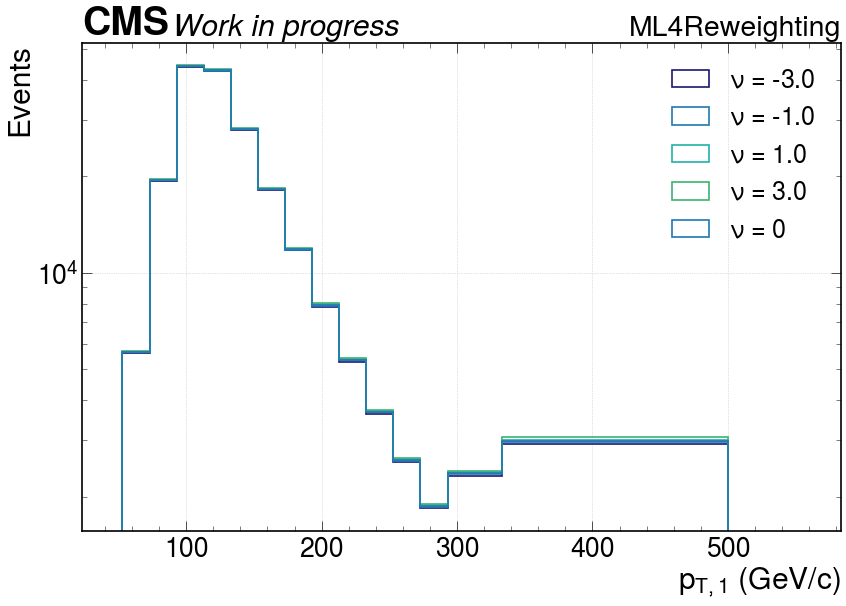

In [11]:
bins = np.append(np.arange(33, 303, 20),np.array([333, 500]))

histo_nu_list = []

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE, constrained_layout=True)
ax.grid(True, which='major', axis='both', alpha=0.5, color='gray')
ax.set_axisbelow(True)
draw_cms_label(ax)

for nu_iter in range(len(nu_list)):
    
    nu     = nu_list[nu_iter]
    nu_std = nu_list_std[nu_iter]
    
    lead_pt_nu    = feature[(nuisance==nu_std) & (targets==1)][:, 0]
    lead_pt_w_nu  = weights[(nuisance==nu_std) & (targets==1)]
    
    histo         = ax.hist(lead_pt_nu, bins=bins, weights=lead_pt_w_nu, histtype='step', lw=2, label=r'$\nu$ = %s'%(str(nu)), color=colors[nu_iter])[0]
    
    histo_nu_list.append(histo)

lead_pt_ref    = feature[(targets==0)][:, 0]
lead_pt_w_ref  = weights[(targets==0)]*1./len(nu_list) # normalize the reference weights to the number of nuisance parameters

histo_ref_0    = ax.hist(lead_pt_ref, bins=bins, weights=lead_pt_w_ref, histtype='step', lw=2, label=r'$\nu$ = %s'%(str(0)))[0]

ax.legend(fontsize=FONTSIZE-6, loc='upper right')

ax.set_yscale('log')

ax.set_xlabel(xlabel_dict['leadmupt'], fontsize=FONTSIZE)
ax.set_ylabel('Events', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

ax.set_xlim(bins[0] - (bins[1] - bins[0])/2, bins[-1] + (bins[-1] - bins[-2])/2)

if PLOT:
    fig.savefig(os.path.join(PLOT_FOLDER, 'leadmupt_nuisance.pdf'), bbox_inches='tight', dpi=300, facecolor='w')

plt.show()

## Plot leading pt ratios

/tmp/nilai/ipykernel_3904718/1253937579.py:31: RuntimeWarning: invalid value encountered in divide
  ratio = histo_nu*1./(histo_ref)
/tmp/nilai/ipykernel_3904718/1253937579.py:32: RuntimeWarning: invalid value encountered in divide
  ratio_err = ratio*np.sqrt( (histo_nu_sq*1./histo_nu**2) + (histo_ref_sq*1./histo_ref**2) )


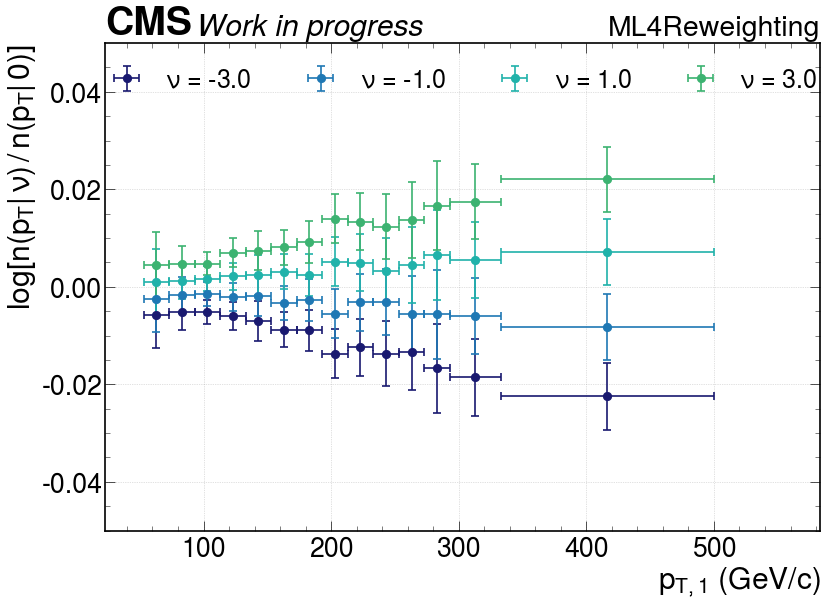

In [12]:
bins = np.append(np.arange(33, 303, 20),np.array([333, 500])) 
bincenters = 0.5*(bins[1:]+bins[:-1])
binwidths = bins[1:]-bins[:-1]

fig, ax = plt.subplots(1, 1, figsize=FIGSIZE, constrained_layout=True)
ax.grid(True, which='major', axis='both', alpha=0.5, color='gray')
ax.set_axisbelow(True)
draw_cms_label(ax)

ratios = []
log_ratios = []
ratio_errs = []
log_ratio_errs = []

for nu_iter in range(len(nu_list)):
    nu = nu_list[nu_iter]
    nu_std = nu_list_std[nu_iter]
    
    lead_pt_ref   = feature[(nuisance==nu_std) & (targets==0)][:, 0]
    lead_pt_w_ref = weights[(nuisance==nu_std) & (targets==0)]
    
    lead_pt_nu    = feature[(nuisance==nu_std) & (targets==1)][:, 0]
    lead_pt_w_nu  = weights[(nuisance==nu_std) & (targets==1)]

    histo_ref = np.histogram(lead_pt_ref, bins=bins, weights=lead_pt_w_ref)[0]
    histo_nu  = np.histogram(lead_pt_nu,  bins=bins, weights=lead_pt_w_nu)[0]
    
    histo_ref_sq = np.histogram(lead_pt_ref, bins=bins, weights=lead_pt_w_ref**2)[0]
    histo_nu_sq  = np.histogram(lead_pt_nu,  bins=bins, weights=lead_pt_w_nu**2)[0]
    
    ratio = histo_nu*1./(histo_ref)
    ratio_err = ratio*np.sqrt( (histo_nu_sq*1./histo_nu**2) + (histo_ref_sq*1./histo_ref**2) )
    
    log_ratio = np.log(ratio)
    log_ratio_err = ratio_err*1./ratio
    
    ratios.append(ratio)
    log_ratios.append(log_ratio)
    ratio_errs.append(ratio_err)
    log_ratio_errs.append(log_ratio_err)
    
    ax.errorbar(
        x          = bincenters, 
        y          = log_ratio, 
        yerr       = log_ratio_err, 
        xerr       = binwidths/2,
        marker     = 'o',
        ls         = '',
        lw         = 2,
        label      = r'$\nu$ = %s'%(str(nu)), 
        color      = colors[nu_iter], 
        markersize = 10,
        elinewidth = 2,
        capsize    = 5,
        capthick   = 2
    )
    
ax.set_xlabel(xlabel_dict['leadmupt'], fontsize=FONTSIZE)
ax.set_ylabel(r'$log[n({\rm p_T}|\,\nu)\,/ \, n({\rm p_T}|\,0)]$', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

ax.legend(fontsize=FONTSIZE-6, loc='upper center', ncol=4)

ax.set_xlim(bins[0] - (bins[1] - bins[0])/2, bins[-1] + (bins[-1] - bins[-2])/2)
ax.set_ylim(-0.05, 0.05)

if PLOT:
    fig.savefig(os.path.join(PLOT_FOLDER, 'leadmupt_nuisance_ratio.pdf'), bbox_inches='tight', dpi=300, facecolor='w')
    
plt.show()

## Binned approach - visualization only

In [13]:
# bins       = np.append(np.arange(33, 303, 20),np.array([333, 500]))
# bincenters = 0.5*(bins[1:]+bins[:-1])
# binwidths  = bins[1:]-bins[:-1]
# n_bins     = len(bincenters)

# ratios = np.array(ratios)
# log_ratios = np.array(log_ratios)
# ratio_errs = np.array(ratio_errs)
# log_ratio_errs = np.array(log_ratio_errs)

# for bin_idx in range(n_bins):
#     # print("Range:", bins[bin_idx], bins[bin_idx+1])
    
#     r         = ratios[:, bin_idx]
#     log_r     = log_ratios[:, bin_idx]
#     r_err     = ratio_errs[:, bin_idx]
#     log_r_err = log_ratio_errs[:, bin_idx]
    
#     fig, ax = plt.subplots(1, 1, figsize=FIGSIZE, constrained_layout=True)
#     ax.grid(True, which='major', axis='both', alpha=0.5, color='gray')
#     ax.set_axisbelow(True)
#     draw_cms_label(ax)
#     for nu_iter, nu in enumerate(nu_list):
#         ax.errorbar(
#             x          = nu_list[nu_iter], 
#             y          = log_r[nu_iter], 
#             yerr       = log_r_err[nu_iter], 
#             marker     = 'o',
#             ls         = '',
#             lw         = 2,
#             # label      = r'$p_{\rm{T},1}\in$[%s, %s] (GeV/$c$)'%(bins[bin_idx], bins[bin_idx+1]),
#             color      = colors[nu_iter], 
#             markersize = 10,
#             elinewidth = 2,
#             capsize    = 5,
#             capthick   = 2
#         )
        
#     ax.plot([], [], label = r'$p_{\rm{T},1}\in$[%s, %s] (GeV/$c$)'%(bins[bin_idx], bins[bin_idx+1]), ls='', marker='')
    
#     ax.set_xlabel(r"$\nu$", fontsize=FONTSIZE)
#     ax.set_ylabel(r'$log[n({\rm p_T}|\,\nu)\,/ \, n({\rm p_T}|\,0)]$', fontsize=FONTSIZE)
    
#     ax.legend(loc='upper left', fontsize=FONTSIZE)
    
#     ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
    
#     ax.set_xlim(-3.5, 3.5)
#     ax.set_ylim(-0.04, 0.04)
    
#     if PLOT:
#         fig.savefig(os.path.join(PLOT_FOLDER, 'leadmupt_nuisance_ratio_%s_%s.pdf'%(bins[bin_idx], bins[bin_idx+1])), bbox_inches='tight', dpi=300, facecolor='w')
    
#     plt.show()


## Classifier approach

### Data preprocessing - standardization

In [14]:
# # for each feature columns (pt1, pt2, eta1, eta2, deltaphi, mass)
for j in range(feature.shape[1]):
    
    # get the j-th feature column
    vec  = feature[:, j]
    
    # get the mean and std of the j-th feature column of the reference sample
    mean = mean_REF[j]
    std  = std_REF[j]
    
    # if the minimum of the j-th feature column is less than 0, subtract the mean and divide by the std (assume gaussian)
    if np.min(vec) < 0:
        vec = vec - mean
        vec = vec * 1./ std
    # otherwise, if the maximum of the j-th feature column is greater than 1, divide by the mean (assume exponential)
    elif np.max(vec) > 1.0:
        vec = vec * 1./ mean
        
    # replace the j-th feature column with the normalized version
    feature[:, j] = vec

# keep only pt1 and pt2 columns and concatenate with the year label ---> shape (n_samples, 3)
feature = np.concatenate((feature[:, :2], np.expand_dims(yearlab, axis=1)), axis=1)

# include in the target ndarray the event weight and the nuisance parameter of that sample ---> shape (n_samples, 3)
target  = np.stack([targets, weights, nuisance], axis=1)


print(feature.shape)
print(target.shape)

(41635576, 3)
(41635576, 3)


### Train-validation-test split

In [15]:
# split training, validation and test
fraction_validation = 0.2
fraction_test       = 0.2
fraction_training   = 1 - fraction_validation - fraction_test

# shuffle the data
N   = feature.shape[0]
idx = np.arange(N)
np.random.seed(0)
np.random.shuffle(idx)

# masks for splitting the data
mask_val   = (idx <  int(N*fraction_validation))
mask_test  = (idx >= int(N*fraction_validation)) * (idx < int(N*(fraction_validation+fraction_test)))
mask_train = (idx >= int(N*(fraction_validation+fraction_test)))

# split the data
feature_test,  target_test  = feature[mask_test],  target[mask_test]
feature_train, target_train = feature[mask_train], target[mask_train]
feature_val,   target_val   = feature[mask_val],   target[mask_val]

# convert numpy arrays to tensorflow tensors for optimization
feature_test,  target_test  = tf.convert_to_tensor(feature_test,  dtype=tf.float32), tf.convert_to_tensor(target_test,  dtype=tf.float32)
feature_train, target_train = tf.convert_to_tensor(feature_train, dtype=tf.float32), tf.convert_to_tensor(target_train, dtype=tf.float32)
feature_val,   target_val   = tf.convert_to_tensor(feature_val,   dtype=tf.float32), tf.convert_to_tensor(target_val,   dtype=tf.float32)

print(feature_test.shape, feature_train.shape, feature_val.shape)

2023-10-24 19:47:12.806501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10389 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:04:00.0, compute capability: 6.1
2023-10-24 19:47:12.807926: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10403 MB memory:  -> device: 1, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:82:00.0, compute capability: 6.1


(8327115, 3) (24981346, 3) (8327115, 3)


### Neural network model and hyperparameters

In [16]:
# model architecture 
input_size  = 2 # pt1, pt2
input_shape = (None, input_size)
layers      = [input_size, 30, 30, 1]

# create strings for saving files
architecture = ''
for l in layers:
    architecture += str(l)+'_'
    
nu_string = ''
for nu in nu_list:
    nu_string += str(nu)+'_'

# number of training epochs
total_epochs   = 1000
# after how many epochs to gather the loss and accuracy
patience       = 100
# weight-clipping
wc             = 10
# l2 regularization
l2             = None
# polynomial degree of the approximation
poly_degree    = 1
# activation function
activation     = 'sigmoid'
# batch fraction 
batch_fraction = 0.3
# learning rate
learning_rate  = 0.001

# tape gradients after how many batches
gather_after   = int(1./batch_fraction)

# create the model
model = ParametricNet(
    input_shape, 
    architecture = layers, 
    activation   = activation, 
    l2           = l2,
    poly_degree  = poly_degree, 
    name         = 'ParNet'
)

# set the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# clip the initial weights of the model 
clipping = WeightClip(0.1)
for module in model.layers:
    for layer in module.layers:
        layer.set_weights([clipping(w) for w in layer.get_weights()])
            
            
print(model.summary())

Model: "ParNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bs_mfinder_c (BSMfinder_c)  multiple                  1051      
                                                                 
Total params: 1051 (4.11 KB)
Trainable params: 1051 (4.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### Training and validation

In [17]:
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

In [ ]:
TRAIN = True

epoch: 0, loss: 0.028539, val_loss: 0.317114


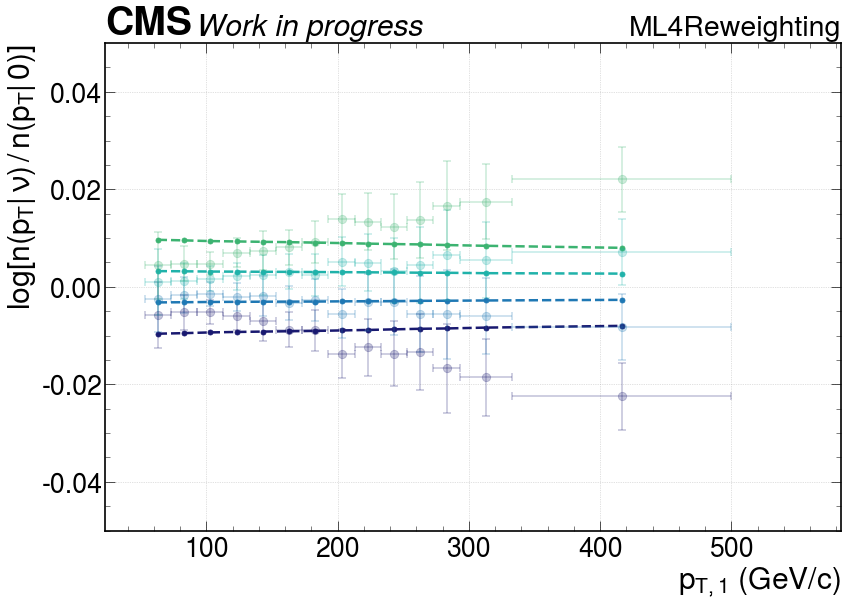

epoch: 100, loss: 0.028539, val_loss: 0.317114


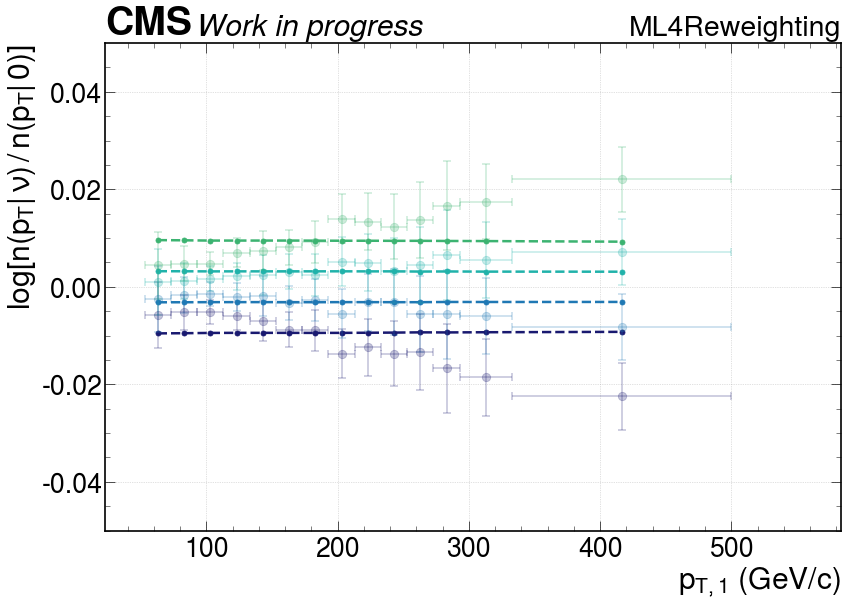

epoch: 200, loss: 0.028539, val_loss: 0.317114


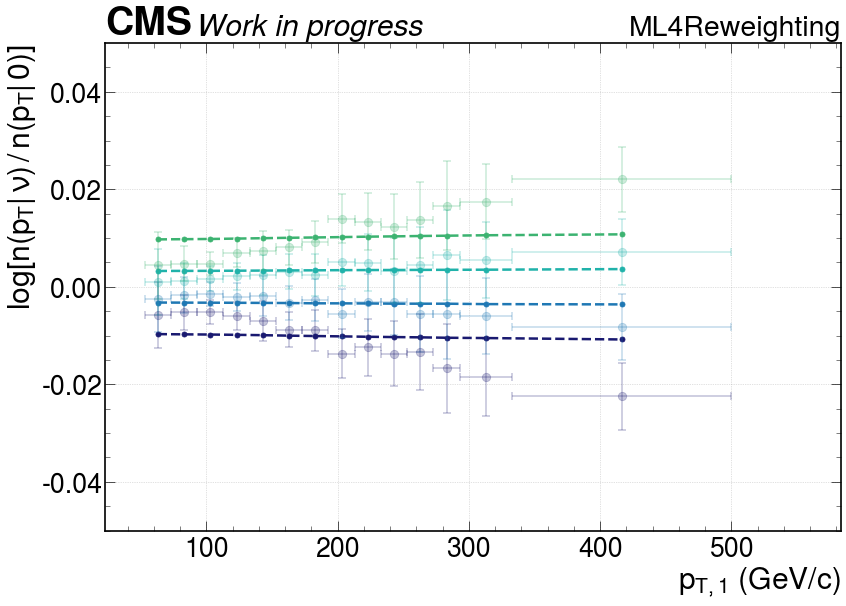

epoch: 300, loss: 0.028539, val_loss: 0.317114


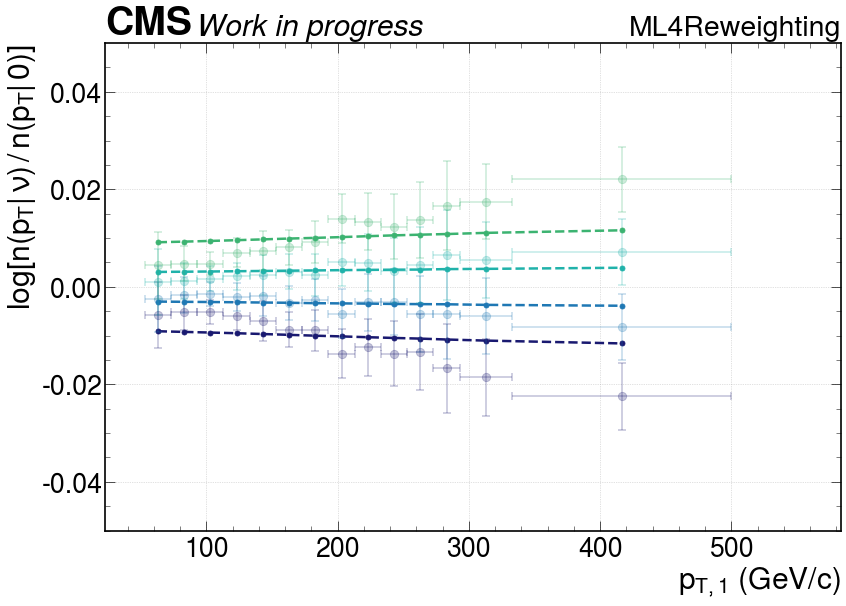

epoch: 400, loss: 0.028539, val_loss: 0.317114


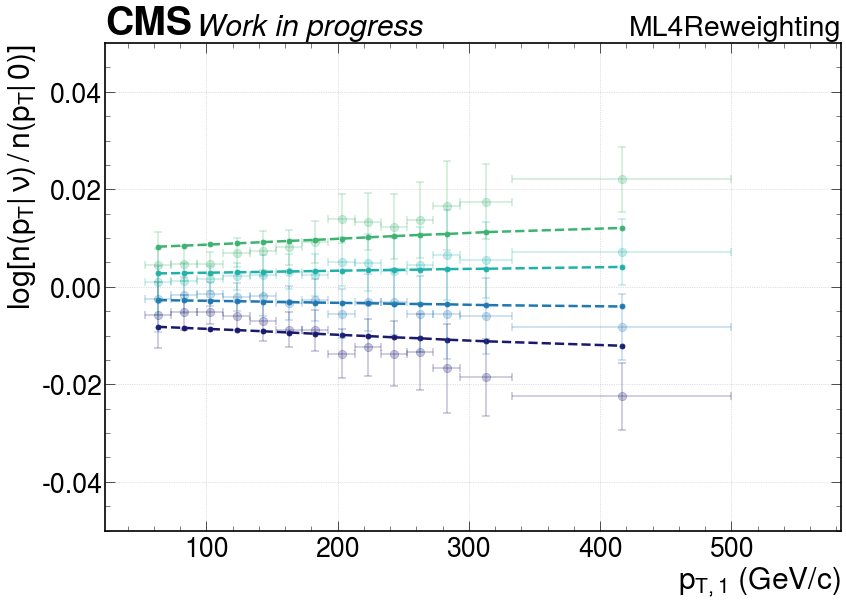

epoch: 500, loss: 0.028539, val_loss: 0.317113


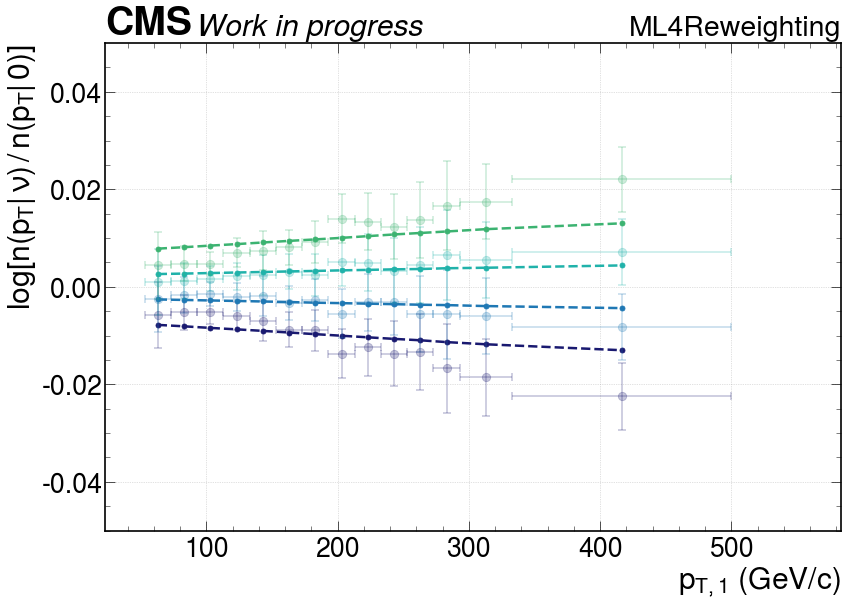

epoch: 600, loss: 0.028539, val_loss: 0.317113


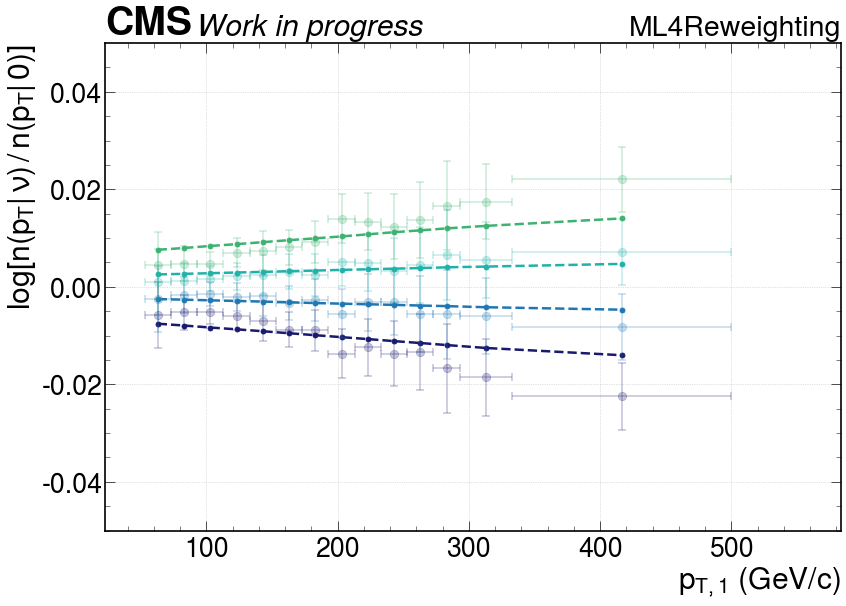

epoch: 700, loss: 0.028539, val_loss: 0.317113


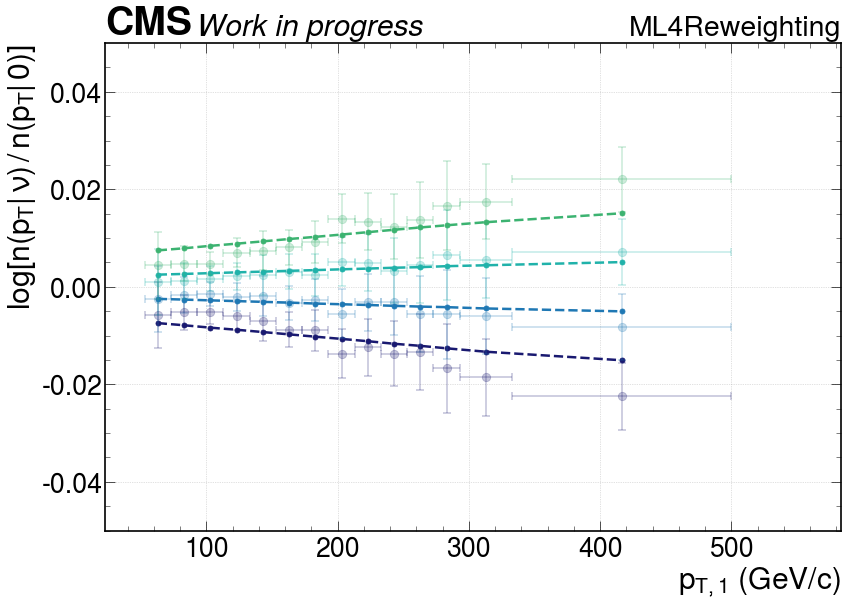

epoch: 800, loss: 0.028539, val_loss: 0.317113


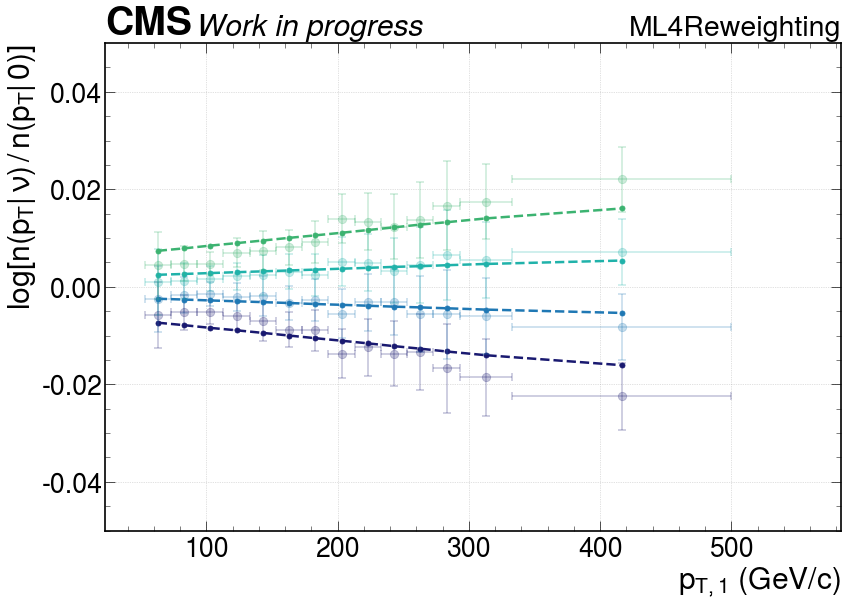

epoch: 900, loss: 0.028539, val_loss: 0.317113


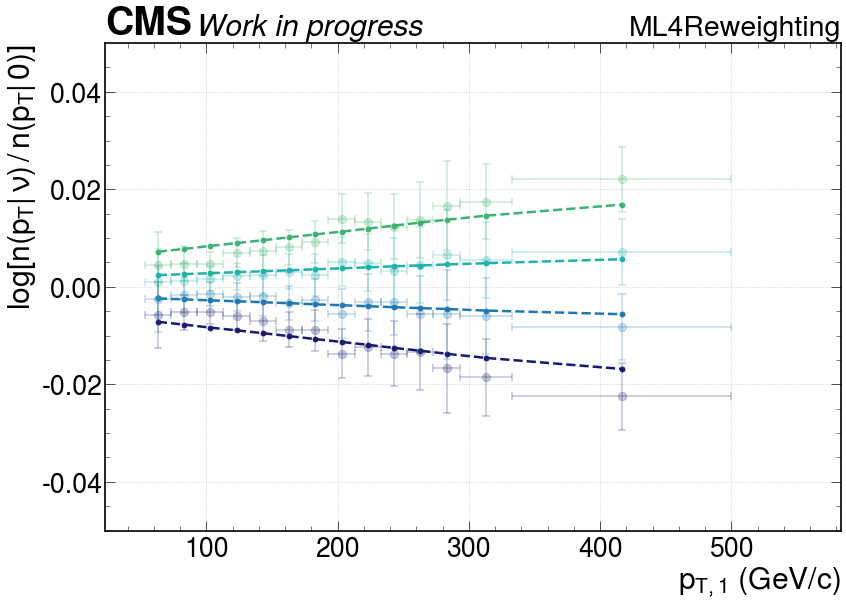

In [24]:
if TRAIN:
    # training                                                                                                                                                                                     
    pars_total = np.array([])
    loss_total = np.array([])
    loss_val_total = np.array([])

    for i in range(int(total_epochs/patience)):
        
        loss = np.array([])
        pars = np.array([])
        train_vars = model.trainable_variables
        clipping = WeightClip(wc)
        #print(train_vars)
        # Create empty gradient list (not a tf.Variable list)                                                                                                                                      
        accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]
        losstot, losstot_tmp = 0, 0
        for j in range(patience):
            if batch_fraction<1:
                feature_tmp, target_tmp = random_pick(feature_train[:, 0:input_size], target_train, seed=j, fraction=batch_fraction)
            else:
                feature_tmp, target_tmp = feature_train[:, 0:input_size], target_train
                
            with tf.GradientTape() as tape:
                pred_tmp = model(feature_tmp)
                loss_value = ParametricLoss_poly(target_tmp, pred_tmp)
                losstot += loss_value
            grads = tape.gradient(loss_value, model.trainable_variables)
            # Accumulate the gradients    
            #print(grads)
            accum_gradient = [(acum_grad+grad) for acum_grad, grad in zip(accum_gradient, grads)]
            losstot_tmp=np.copy(losstot)
            # Now, after executing all the tapes you needed, we apply the optimization step                                                                                                        
            # (but first we take the average of the gradients)                                                                                                                                     
            if j%gather_after==0:
                accum_gradient_mean = [this_grad*1./gather_after for this_grad in accum_gradient]
                optimizer.apply_gradients(zip(accum_gradient_mean,train_vars))
                accum_gradient = [tf.zeros_like(this_var) for this_var in train_vars]
                losstot = 0
            #print('batch/epoch: %i/%i, loss: %f'%(j, int(i*patience), losstot_tmp))
        for module in model.layers:
            for layer in module.layers:
                layer.set_weights([clipping(w) for w in layer.get_weights()])
        pred_val = model(feature_val[:, 0:input_size])
        poly_val = Delta_poly(target_val, pred_val)
        loss_val = ParametricLoss_poly(target_val, pred_val)*1./gather_after
        for par in train_vars:
            pars = np.append(pars, par.numpy())
        pars = np.expand_dims(pars, axis=1).T
        loss = np.append(loss, losstot_tmp/patience)
        loss_val = np.array([loss_val])
        if pars_total.shape[0]==0:
            pars_total = pars
            loss_total = loss
            loss_val_total = loss_val
        else:
            pars_total     = np.concatenate((pars_total, pars), axis=0)
            loss_total     = np.concatenate((loss_total, loss), axis=0)
            loss_val_total = np.concatenate((loss_val_total, loss_val), axis=0)
        print('epoch: %i, loss: %f, val_loss: %f'%(int((i+1)*patience), loss_total[-1], loss_val_total[-1]))
            
        # Saving the data
        f = h5py.File(OUTPUT_PATH + '/%shistory.h5' % (architecture), 'w')
        f.create_dataset('pars',     data=pars_total,     compression='gzip')
        f.create_dataset('loss',     data=loss_total,     compression='gzip')
        f.create_dataset('loss_val', data=loss_val_total, compression='gzip')
        f.close()
        log_weights = '%s/polydeg%i_L2%s_ARC%sNU%sweights_batchfrac%s_gradfreq%i_ep%i.h5' % (
            OUTPUT_PATH, poly_degree, str(l2), architecture, nu_string, str(batch_fraction), gather_after, i * patience
        )
        model.save_weights(log_weights)
        
        if True:
            
            # create figure and axes
            fig, ax = plt.subplots(1, 1, figsize=FIGSIZE, constrained_layout=True)
            ax.grid(True, which='major', axis='both', alpha=0.5, color='gray')
            ax.set_axisbelow(True)
            draw_cms_label(ax)
            
            # for each nuisance parameter
            for nu_iter in range(len(nu_list)):
                nu = nu_list[nu_iter]
                nu_std = nu_list_std[nu_iter]
                
                # plot the already-computed binned log-ratio
                ax.errorbar(
                    x          = bincenters[1:], 
                    y          = log_ratios[nu_iter][1:], 
                    yerr       = log_ratio_errs[nu_iter][1:], 
                    xerr       = binwidths[1:] / 2,
                    marker     = 'o',
                    ls         = '',
                    lw         = 0,
                    label      = r'$\nu$ = %s binned'%(str(nu)), 
                    color      = colors[nu_iter], 
                    markersize = 10,
                    elinewidth = 2,
                    capsize    = 5,
                    capthick   = 2,
                    alpha      = 0.25
                )
                
                # masks to retreive the validation data corresponding to this nuisance parameter
                maskR = (target_val[:, -1]==nu_std).numpy() * (target_val[:, 0]==0).numpy()
                maskD = (target_val[:, -1]==nu_std).numpy() * (target_val[:, 0]==1).numpy()
                
                # retrieve the validation data
                featR = feature_val.numpy()[maskR]
                featD = feature_val.numpy()[maskD]
                
                deltR = np.exp(poly_val[maskR])
                
                # retreive the weights
                weig = target_val[:, 1].numpy()
                weigR = weig[maskR]
                weigD = weig[maskD]
                

                hist_sumD = np.histogram(featD[:, 0]*mean_REF[0], weights=weigD,       bins=bins)[0]
                
                # reweight the reference data
                hist_sumW = np.histogram(featR[:, 0]*mean_REF[0], weights=weigR*deltR, bins=bins)[0]
                
                hist_sum  = np.histogram(featR[:, 0]*mean_REF[0], weights=weigR,       bins=bins)[0]
                
                ax.plot(bincenters[1:], np.log(hist_sumW[1:]/hist_sum[1:]), color=colors[nu_iter], lw=3, ls='--', marker="o", label = r'$\nu$ = %s learned'%(str(nu)))
                
            ax.set_xlabel(xlabel_dict['leadmupt'], fontsize=FONTSIZE)
            ax.set_ylabel(r'$log[n({\rm p_T}|\,\nu)\,/ \, n({\rm p_T}|\,0)]$', fontsize=FONTSIZE)
            ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

            # ax.legend(fontsize=FONTSIZE-12, loc='upper center', ncol=4)

            ax.set_xlim(bins[0] - (bins[1] - bins[0])/2, bins[-1] + (bins[-1] - bins[-2])/2)
            ax.set_ylim(-0.05, 0.05)
            
            fig.savefig(log_weights.replace('.h5', '.pdf'), bbox_inches='tight', dpi=300, facecolor='w')
            plt.show()
                

### Test

In [18]:
# load model weights 
model = ParametricNet(
    input_shape, 
    architecture = layers, 
    activation   = activation, 
    l2           = l2,
    poly_degree  = poly_degree, 
    name         = 'ParNet'
)
log_weights = '%s/polydeg%i_L2%s_ARC%sNU%sweights_batchfrac%s_gradfreq%i_ep%i.h5' % (
        OUTPUT_PATH, poly_degree, str(l2), architecture, nu_string, str(batch_fraction), gather_after, total_epochs-patience
    )
model.load_weights(log_weights)

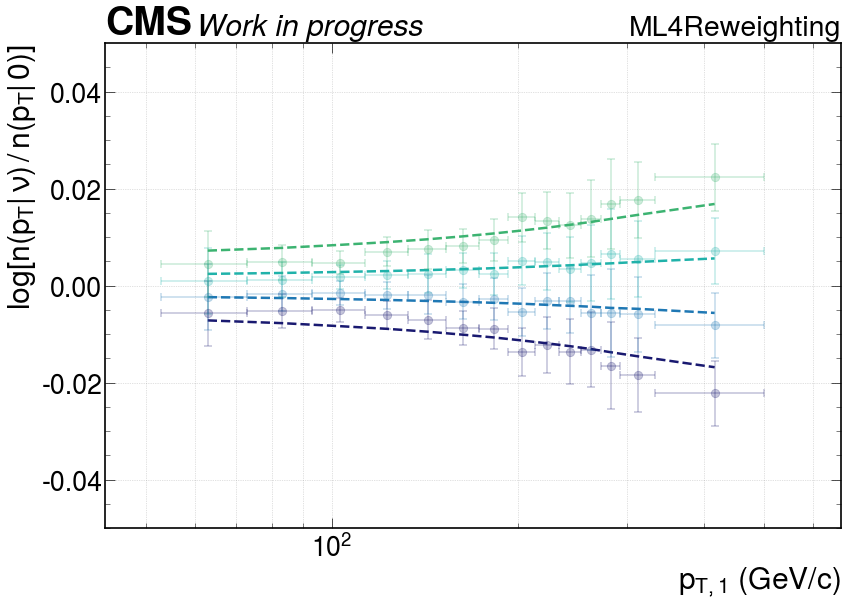

In [23]:
# create figure and axes
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE, constrained_layout=True)
ax.grid(True, which='major', axis='y', alpha=0.5, color='gray')
ax.grid(True, which='both', axis='x', alpha=0.5, color='gray')
ax.set_axisbelow(True)
draw_cms_label(ax)

# for each nuisance parameter
for nu_iter in range(len(nu_list)):
    nu = nu_list[nu_iter]
    nu_std = nu_list_std[nu_iter]
    
    # plot the already-computed binned log-ratio
    ax.errorbar(
        x          = bincenters[1:], 
        y          = log_ratios[nu_iter][1:],
        yerr       = log_ratio_errs[nu_iter][1:], 
        xerr       = binwidths[1:] / 2,
        marker     = 'o',
        ls         = '',
        lw         = 0,
        label      = r'$\nu$ = %s binned'%(str(nu)), 
        color      = colors[nu_iter], 
        markersize = 10,
        elinewidth = 2,
        capsize    = 5,
        capthick   = 2,
        alpha      = 0.25
    )
    
    # masks to retreive the validation data corresponding to this nuisance parameter
    maskR = (target_test[:, -1]==nu_std).numpy() * (target_test[:, 0]==0).numpy()
    maskD = (target_test[:, -1]==nu_std).numpy() * (target_test[:, 0]==1).numpy()
    
    # retrieve the validation data
    featR = feature_test.numpy()[maskR]
    featD = feature_test.numpy()[maskD]
    
    pred_test = model(feature_test[:, 0:input_size])
    poly_test = Delta_poly(target_test, pred_test)
    deltR = np.exp(poly_test[maskR])
    
    # retreive the weights
    weig = target_test[:, 1].numpy()
    weigR = weig[maskR]
    weigD = weig[maskD]
    

    hist_sumD = np.histogram(featD[:, 0]*mean_REF[0], weights=weigD,       bins=bins)[0]
    
    # reweight the reference data
    hist_sumW = np.histogram(featR[:, 0]*mean_REF[0], weights=weigR*deltR, bins=bins)[0]
    
    hist_sum  = np.histogram(featR[:, 0]*mean_REF[0], weights=weigR,       bins=bins)[0]
    
    ax.plot(bincenters[1:], np.log(hist_sumW[1:]/hist_sum[1:]), color=colors[nu_iter], lw=3, ls='--', label = r'$\nu$ = %s learned'%(str(nu)))
    
ax.set_xlabel(xlabel_dict['leadmupt'], fontsize=FONTSIZE)
ax.set_ylabel(r'$log[n({\rm p_T}|\,\nu)\,/ \, n({\rm p_T}|\,0)]$', fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-4)

# ax.legend(fontsize=FONTSIZE-12, loc='upper center', ncol=4)

ax.set_xlim(bins[1] - (bins[2] - bins[1])/2, bins[-1] + (bins[-1] - bins[-2]))
ax.set_ylim(-0.05, 0.05)

ax.set_xscale("log")

# fig.savefig(log_weights.replace('.h5', 'test.pdf'), bbox_inches='tight', dpi=300, facecolor='w')
plt.show()